In [23]:
import sys
print(sys.executable)
%pip install clickhouse-connect numpy pandas matplotlib scikit-learn keras tensorflow


/home/nick/git/qrust/.venv/bin/python
Note: you may need to restart the kernel to use updated packages.


In [24]:
from clickhouse_connect import get_client


In [25]:
def get_bars(client, symbol):
    query = f"""
WITH bars AS (
    SELECT symbol,
        time,
        open,
        high,
        low,
        close,
        volume
    FROM bars FINAL
    WHERE symbol = '{symbol}'
    ORDER BY time WITH FILL step INTERVAL 1 MINUTE INTERPOLATE (
            symbol AS symbol,
            open AS close,
            high AS close,
            low AS close,
            close AS close
        )
),
news AS (
    SELECT time_updated AS time,
        symbols,
        CAST(sentiment, 'Int8') * confidence AS score
    FROM news FINAL
    WHERE has(symbols, '{symbol}')
),
grouped AS (
    SELECT toStartOfHour(bars.time),
        toHour(toStartOfHour(bars.time)) AS time,
        toDayOfWeek(calendar.date) AS day_of_week,
        any(bars.open) AS open,
        max(bars.high) AS high,
        min(bars.low) AS low,
        anyLast(bars.close) AS close,
        sum(bars.volume) AS volume,
        avg(news.score) AS score
    FROM bars
        INNER JOIN calendar ON toDate(bars.time) = calendar.date
        LEFT JOIN news ON toStartOfHour(bars.time) = toStartOfHour(news.time)
    WHERE bars.time BETWEEN calendar.open AND calendar.close
    GROUP BY toStartOfHour(bars.time),
        toDayOfWeek(calendar.date)
    ORDER BY toStartOfHour(bars.time)
)
SELECT time,
    day_of_week,
    open,
    high,
    low,
    close,
    volume,
    score
FROM grouped
    """

    return client.query_df(query)

def get_symbols(client):
    query = """
    SELECT symbol
    FROM assets FINAL
    WHERE class = 'us_equity'
    """
    return client.query_df(query)

client = get_client(host='localhost', port=8123, user='qrust', password='qrust', database='qrust')

symbols = get_symbols(client)

bars = {}
for symbol in symbols['symbol']:
    bars[symbol] = get_bars(client, symbol)

bars


{'AAPL':       time  day_of_week     open     high      low    close    volume  \
0       14            1   92.110   92.320   91.870   92.090   74648.0   
1       15            1   92.120   92.210   91.290   91.750   53624.0   
2       16            1   91.750   92.010   91.580   92.010   34056.0   
3       17            1   92.040   92.340   91.980   92.340   64616.0   
4       18            1   92.350   92.470   92.100   92.100  103912.0   
...    ...          ...      ...      ...      ...      ...       ...   
7185    17            5  182.900  183.020  182.310  182.800   72038.0   
7186    18            5  182.805  182.970  182.610  182.725   53376.0   
7187    19            5  182.735  182.750  182.440  182.610   53989.0   
7188    20            5  182.605  182.815  182.445  182.500  194456.0   
7189    21            5  182.500  182.500  182.500  182.500       0.0   

         score  
0     0.000000  
1     0.000000  
2     0.000000  
3    -0.861785  
4     0.000000  
...        .

## Data Preprocessing


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

np.random.seed(0)


In [27]:
scaler = StandardScaler()

def scale(df, keys):
    df.loc[:, keys] = scaler.fit_transform(df[keys])

    return df


In [28]:
def position(df):
    smooth_close = df['close'].rolling(window=32).mean()
    smooth_close = smooth_close.shift(-16)
    derivative = smooth_close.diff()

    df['position'] = np.where(derivative > 0, 1, 0)

    return df


In [29]:
def sma(df):
    df['sma_6'] = df['close'].rolling(window=6).mean()
    df['sma_12'] = df['close'].rolling(window=12).mean()
    df['sma_24'] = df['close'].rolling(window=24).mean()
    df['sma_48'] = df['close'].rolling(window=48).mean()
    df['sma_72'] = df['close'].rolling(window=72).mean()

    return df


In [30]:
def ema(df):
    df['ema_6'] = df['close'].ewm(span=6, adjust=False).mean()
    df['ema_12']  = df['close'].ewm(span=12, adjust=False).mean()
    df['ema_24']  = df['close'].ewm(span=24, adjust=False).mean()
    df['ema_48']  = df['close'].ewm(span=48, adjust=False).mean()
    df['ema_72']  = df['close'].ewm(span=72, adjust=False).mean()

    return df


In [31]:
def macd(df):
    ema_12 = df['close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['close'].ewm(span=26, adjust=False).mean()

    df['macd'] = ema_12 - ema_26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

    return df


In [32]:
def rsi(df):
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()

    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))

    return df


In [33]:
def preprocess(df):
    df = position(df)

    df = sma(df)
    df = ema(df)
    df = macd(df)
    df = rsi(df)

    df = scale(df, ['open', 'high', 'low', 'close', 'volume', 'sma_6', 'sma_12', 'sma_24', 'sma_48', 'sma_72', 'ema_6', 'ema_12', 'ema_24', 'ema_48', 'ema_72', 'macd', 'macd_signal'])
    df = df.dropna()

    return df


In [34]:
data = bars.copy()
data = {k: preprocess(v) for k, v in data.items()}
data


{'AAPL':       time  day_of_week      open      high       low     close    volume  \
 71      21            4 -1.684193 -1.699834 -1.650000 -1.667291 -0.273717   
 72      14            5 -1.734334 -1.711148 -1.700097 -1.680271 -0.136885   
 73      15            5 -1.697255 -1.710729 -1.705149 -1.721305 -0.112472   
 74      16            5 -1.743182 -1.739643 -1.737144 -1.748103 -0.057222   
 75      17            5 -1.768463 -1.776101 -1.765772 -1.770714 -0.032899   
 ...    ...          ...       ...       ...       ...       ...       ...   
 7185    17            5  1.339828  1.312727  1.346601  1.333631 -0.183914   
 7186    18            5  1.335825  1.310631  1.359231  1.330490 -0.207178   
 7187    19            5  1.332875  1.301412  1.352074  1.325675 -0.206414   
 7188    20            5  1.327398  1.304136  1.352285  1.321069 -0.031308   
 7189    21            5  1.322974  1.290936  1.354600  1.321069 -0.273717   
 
       score  position     sma_6  ...    sma_48    sma

## Windowing & Train/Test Split

In [35]:
from sklearn.model_selection import train_test_split
from numpy.lib.stride_tricks import sliding_window_view


In [39]:
def window(data, window_size, features, target):
    X = []
    y = []

    for _, df in data.items():
        feature_data = df[features].values
        target_data = df[target].values

        X.append(sliding_window_view(feature_data, window_shape=(window_size, len(features))))
        y.append(target_data[window_size - 1:])

    X = np.concatenate(X)
    y = np.concatenate(y)

    return X, y

window_size = 72
features = ['time', 'day_of_week', 'open', 'high', 'low', 'close', 'volume', 'score', 'sma_6', 'sma_12', 'sma_24', 'sma_72', 'ema_6', 'ema_12', 'ema_24', 'ema_72', 'macd', 'macd_signal', 'rsi']
target = 'position'

X, y = window(data, window_size, features, target)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

X_train = X_train.reshape(X_train.shape[0], window_size, len(features))
X_test = X_test.reshape(X_test.shape[0], window_size, len(features))


In [41]:
if np.isnan(X_train).any() or np.isnan(X_test).any() or np.isnan(y_train).any() or np.isnan(y_test).any():
    print('Warning: NaN values are present in the data')

if np.isinf(X_train).any() or np.isinf(X_test).any() or np.isinf(y_train).any() or np.isinf(y_test).any():
    print('Warning: Inf values are present in the data')


In [42]:
%env CUDA_HOME=/opt/cuda
%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/opt/cuda

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.saving import load_model


env: CUDA_HOME=/opt/cuda
env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/opt/cuda


## LSTM 0

- 128/64/32 units
- .25 dropout
- 100 epochs
- 64 batch size

### Results

- Good fit
- Good generalization
- Validation loss: 0.2498517781496048 ~= 0.7789162269

In [43]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(window_size, len(features))))
model.add(Dropout(0.25))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 72, 128)           75776     
                                                                 
 dropout_3 (Dropout)         (None, 72, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 72, 64)            49408     
                                                                 
 dropout_4 (Dropout)         (None, 72, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [44]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    './models/model_0.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1,
    mode='min'
)


2024-02-26 18:41:22.897242: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1395173952 exceeds 10% of free system memory.
2024-02-26 18:41:27.673160: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1395173952 exceeds 10% of free system memory.


Epoch 1/100
3980/3984 [============================>.] - ETA: 0s - loss: 0.5475
Epoch 1: val_loss improved from inf to 0.53959, saving model to model.keras
3984/3984 [==============================] - 40s 9ms/step - loss: 0.5475 - val_loss: 0.5396
Epoch 2/100
3983/3984 [============================>.] - ETA: 0s - loss: 0.5382
Epoch 2: val_loss improved from 0.53959 to 0.53258, saving model to model.keras
3984/3984 [==============================] - 34s 9ms/step - loss: 0.5382 - val_loss: 0.5326
Epoch 3/100
3982/3984 [============================>.] - ETA: 0s - loss: 0.5334
Epoch 3: val_loss improved from 0.53258 to 0.52713, saving model to model.keras
3984/3984 [==============================] - 45s 11ms/step - loss: 0.5334 - val_loss: 0.5271
Epoch 4/100
3980/3984 [============================>.] - ETA: 0s - loss: 0.5280
Epoch 4: val_loss improved from 0.52713 to 0.52513, saving model to model.keras
3984/3984 [==============================] - 38s 9ms/step - loss: 0.5280 - val_loss: 0.

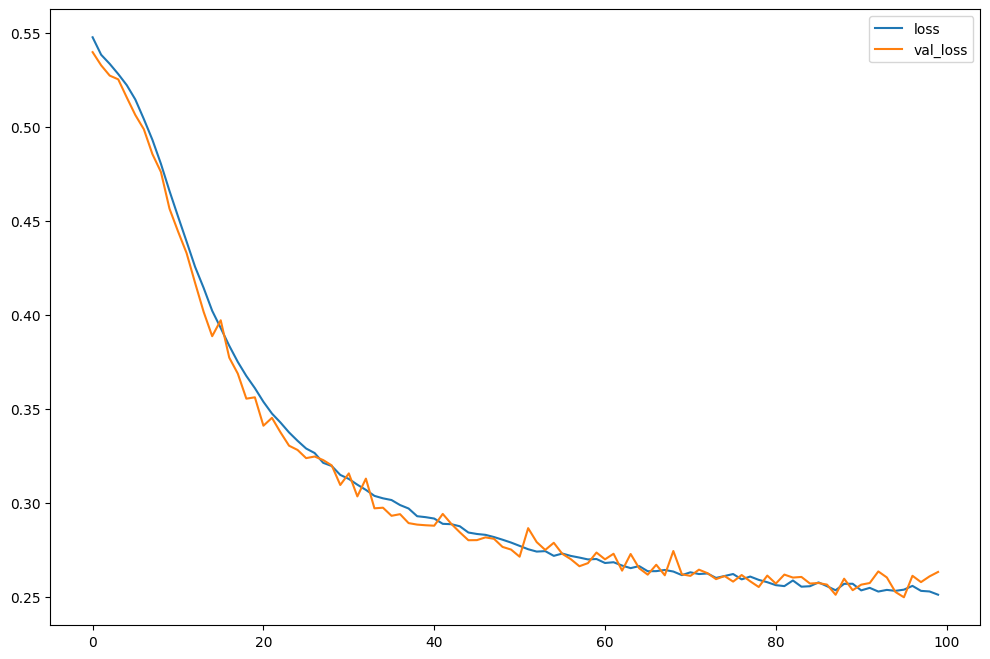

2656/2656 [==============================] - 11s 4ms/step - loss: 0.2499
0.2498517781496048


In [46]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint], verbose=1)

plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

model = load_model('./models/model_0.keras')
evaluation = model.evaluate(X_test, y_test)
print(evaluation)


## LSTM 1

- 256/64/32 units
- .15 dropout
- 100 epochs
- 64 batch size

### Results

- Slightly overfitted
- Good generalization
- Validation loss: 0.22676503658294678 ~= 0.7971080515

In [50]:
model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(window_size, len(features))))
model.add(Dropout(0.15))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.15))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.15))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 72, 256)           282624    
                                                                 
 dropout_9 (Dropout)         (None, 72, 256)           0         
                                                                 
 lstm_10 (LSTM)              (None, 72, 64)            82176     
                                                                 
 dropout_10 (Dropout)        (None, 72, 64)            0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [51]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    './models/model_1.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1,
    mode='min'
)


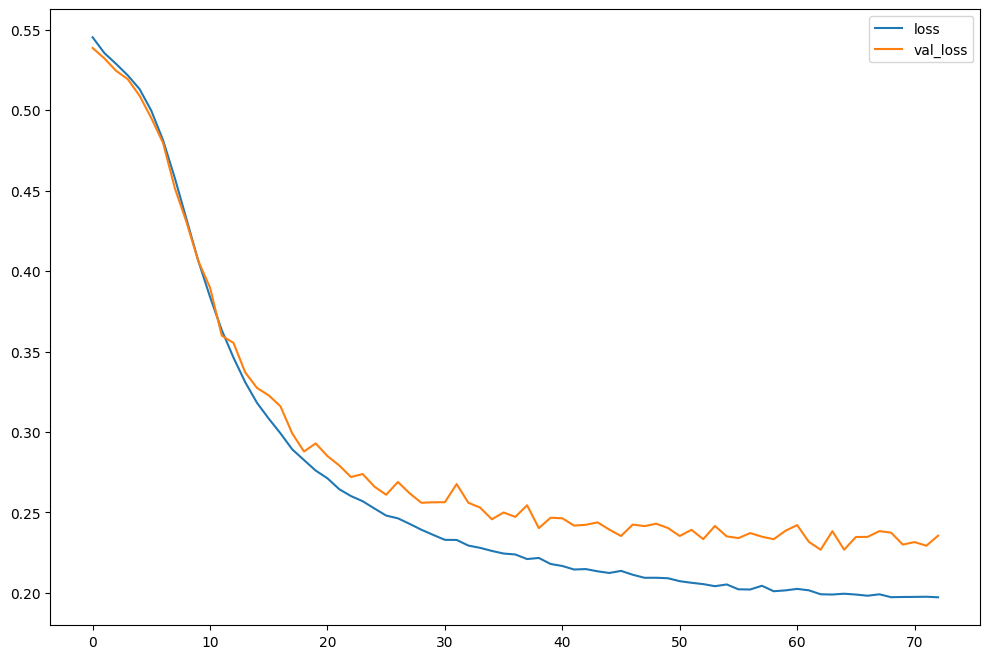

2656/2656 [==============================] - 12s 4ms/step - loss: 0.2268
0.22676503658294678


In [54]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint], verbose=1)

plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

model = load_model('./models/model_1.keras')
evaluation = model.evaluate(X_test, y_test)
print(evaluation)


## TODO

- [ ] Turn features into categorical data
- [ ] Try 3-class classification (buy, hold, sell)
- [ ] Preprocess data using SQL
- [ ] Use LSTM to backtest
